In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,mean_squared_error, mean_absolute_percentage_error
from scipy import stats 
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
import re

import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.ar_model import AutoReg

from scipy.interpolate import interp1d

import wget

sns.set(rc={'figure.figsize':(11.7,8.27)})

## 1. Data Understanding

First we have to find data related to Dioxid of Carbone(C02) concentration in the Atmosphere. We can get this information from the Scripps Institution of Oceanography which can shoe monthly, weekly, dayli datasets. For our project, we will use the montly report: monthly_in_situ_co2_mlo.csv.
- source: https://scrippsco2.ucsd.edu/data/atmospheric_co2/primary_mlo_co2_record.html

The information recollected comes the observatory located at about 3,400 m altitude on Mauna Loa Volcano on Hawaii Island. This place has not influence of changing CO2 due it is near local vegetation and the wind prevail well-mixed air to the site. This information is provided from March 1958.



In [14]:
# Download raw data from source:
DataRaw_C02_url = 'https://scrippsco2.ucsd.edu/assets/data/atmospheric/stations/in_situ_co2/monthly/monthly_in_situ_co2_mlo.csv'
DataRaw_C02 = wget.download(DataRaw_C02_url)
print(DataRaw_C02)

monthly_in_situ_co2_mlo (1).csv


In [3]:
# Create the dataframe from csv file:
cols = ["year", "month", "date1", "date2", "co2", "co2_season_adj", "co2_spline_season_adj", "co2_spline", "co2_fill_7", "co2_fill_8"]
df_co2=pd.read_csv("./monthly_in_situ_co2_mlo.csv", skiprows = 57, header=None, names=cols)
print('Dataframe has {:d} data points of {:d} features'.format(df_co2.shape[0],df_co2.shape[1]))
df_co2.head()

Dataframe has 780 data points of 10 features


,year,month,date1,date2,co2,co2_season_adj,co2_spline_season_adj,co2_spline,co2_fill_7,co2_fill_8
0,1958,1,21200,1958.0411,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99
1,1958,2,21231,1958.1260,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99
2,1958,3,21259,1958.2027,315.71,314.44,316.20,314.91,315.71,314.44
3,1958,4,21290,1958.2877,317.45,315.16,317.30,314.99,317.45,315.16
4,1958,5,21320,1958.3699,317.51,314.70,317.88,315.07,317.51,314.70


## 2. Pre-Processing

After a quick review, the raw dataset has some information which need to be pre-processed before using in the model:
- Usage only the columns year, month, co2(ppm).
- Add columns like time t= (t+0.5)/12.
- Delete comments in " " " and headers which cannot help us to understand the data(skiprows = 57).
- Drop co2 values equal to -99.99 which are some inhomogeneities.
- Drop NaN values.

In [4]:
# Pre-process the dataset:
df_co2 = df_co2.iloc[:,[x for x in range(df_co2.shape[1]) if x in [0,1,4]]]
df_co2["time"] = [(i+0.5)/12 for i in range(0, df_co2.iloc[:,0].size)]
df_co2[df_co2 == -99.99] = np.NaN
df_co2 = df_co2.dropna()
print('Dataframe has {:d} data points of {:d} features'.format(df_co2.shape[0],df_co2.shape[1]))
df_co2.head()

Dataframe has 768 data points of 4 features


,year,month,co2,time
2,1958,3,315.71,0.208333
3,1958,4,317.45,0.291667
4,1958,5,317.51,0.375000
6,1958,7,315.87,0.541667
7,1958,8,314.93,0.625000


For further modeling, we will split the data into train and test dataset. 

In [6]:
# Take values for x and y
x = df_co2["time"].values
y = df_co2["co2"].values

# Split data
x_train, x_test, y_train, y_test = train_test_split(x.reshape(-1,1), y.reshape(-1,1), test_size = 0.20, shuffle=False )

# Define training and testing dataset:
df_co2_train = df_co2[0:len(x_train)]
df_co2_test = df_co2[len(x_train):len(df_co2)]

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape, df_co2_train.shape, df_co2_test.shape)

(614, 1) (154, 1) (614, 1) (154, 1) (614, 4) (154, 4)


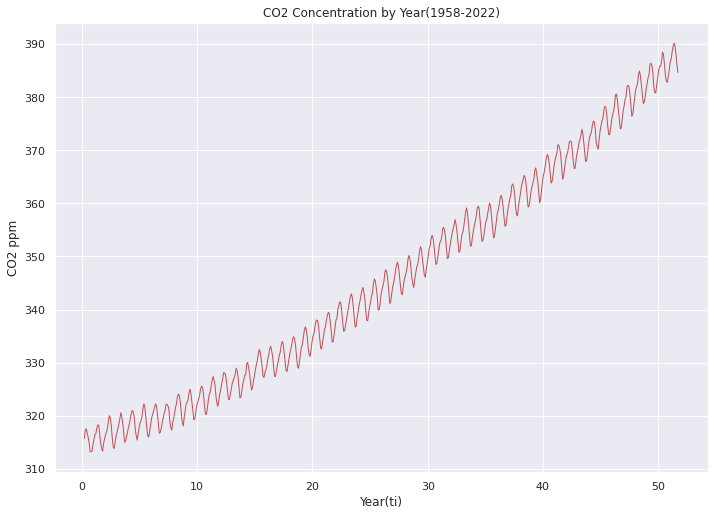

In [53]:
# Plotting The Keeling Curve
plt.plot(x_train[:,0],y_train[:,0], linewidth = 1, color = 'r')
plt.xlabel('Year(ti)')
plt.ylabel('CO2 ppm')
plt.title('CO2 Concentration by Year(1958-2022)')
plt.savefig('./images/CO2-curve.jpg')
plt.show()

# 3. Build Model

We will use information regarded to C02 concentration which can be model as:

$$ C_ i = F(t_ i) + P_ i + R_ i $$

- $F(t_ i)$ : Trendy pattern
- $P_ i$ : Seasonal pattern
- $R_ i$ : Residual

Later during evaluation we will see if this decomposition is meaningful. The main idea is to transform the data into stationarity


## Trendy pattern:

For this part, we need to go throught some models like linear regression, polynomical grade 2, 3 and try to verify which one can fit better.

In [22]:
# Linear Regression Model

modelLR = LinearRegression().fit(x_train, y_train)

alpha0 = modelLR.intercept_
alpha1 = modelLR.coef_[0]
y_pred_train = modelLR.predict(x_train)

# Evaluation for testing dataset
y_pred_test = modelLR.predict(x_test)
R_1 = modelLR.score(x_test, y_test)
rmse_1 = mean_squared_error(y_true=y_test,y_pred=y_pred_test,squared=False)
mape_1 = mean_absolute_percentage_error(y_true=y_test,y_pred=y_pred_test)

print("Linear Regression Model:")
print("=========================")
print("R2 score: ",R_1)
print("RMSE:",rmse_1)
print("MAPE: ", mape_1)
print("F(t) = {:f}*t + {:f}".format(alpha1[0], alpha0[0]))

Linear Regression Model:
R2 score:  -0.699047254153969
RMSE: 12.205045063273001
MAPE:  0.027995356835597913
F(t) = 1.430446*t + 308.558541


In [24]:
# Quadratic Model

grade = 2
Pft = PolynomialFeatures(grade, include_bias=False)
x_train_pol2 = Pft.fit_transform(x_train)
x_test_pol2 = Pft.fit_transform(x_test)

# Create model and fit it:
modelPoly2 = LinearRegression().fit(x_train_pol2, y_train)

alpha0 = modelPoly2.intercept_
alpha1 = modelPoly2.coef_[0][0]
alpha2 = modelPoly2.coef_[0][1]
y_pred_train_pol2 = modelPoly2.predict(x_train_pol2)

# Evaluation for testing dataset
y_pred_test_pol2 = modelPoly2.predict(x_test_pol2)
R_2 = modelPoly2.score(x_test_pol2, y_test)
rmse_2 = mean_squared_error(y_true=y_test,y_pred=y_pred_test_pol2,squared=False)
mape_2 = mean_absolute_percentage_error(y_true=y_test,y_pred=y_pred_test_pol2)

print("Quadratic Model:")
print("=========================")
print("R2 score: ",R_2)
print("RMSE:",rmse_2)
print("MAPE: ", mape_2)
print("Quadratic Fit: F(t) = {:f}*t^2 + {:f}*t + {:f}".format(alpha2, alpha1, alpha0[0]))

Quadratic Model:
R2 score:  0.9093916972185182
RMSE: 2.8185169840722186
MAPE:  0.005867396936490818
Quadratic Fit: F(t) = 0.012107*t^2 + 0.799038*t + 314.132792


In [25]:
# Cubic Model

grade = 3
Pft = PolynomialFeatures(grade, include_bias=False)
x_train_pol3 = Pft.fit_transform(x_train)
x_test_pol3 = Pft.fit_transform(x_test)

# Create model and fit it:
modelPoly3 = LinearRegression().fit(x_train_pol3, y_train)

alpha0 = modelPoly3.intercept_
alpha1 = modelPoly3.coef_[0][0]
alpha2 = modelPoly3.coef_[0][1]
alpha3 = modelPoly3.coef_[0][2]
y_pred_train_pol3 = modelPoly3.predict(x_train_pol3)

# Evaluation for testing dataset
y_pred_test_pol3 = modelPoly3.predict(x_test_pol3)
R_3 = modelPoly3.score(x_train_pol3, y_train)
rmse_3 = mean_squared_error(y_true=y_test,y_pred=y_pred_test_pol3,squared=False)
mape_3 = mean_absolute_percentage_error(y_true=y_test,y_pred=y_pred_test_pol3)

print("Cubic Model:")
print("=========================")
print("R2 score: ",R_3)
print("RMSE:",rmse_3)
print("MAPE: ", mape_3)
print("Cubic Fit: F(t) = {:f}*t^3 + {:f}*t^2 + {:f}*t + {:f}".format(alpha3, alpha2, alpha1, alpha0[0]))

Cubic Model:
R2 score:  0.9897560738035467
RMSE: 4.173563988095543
MAPE:  0.008556662482153917
Cubic Fit: F(t) = -0.000077*t^3 + 0.018098*t^2 + 0.673546*t + 314.693445


In [34]:
x_test[0,:]

array([51.79166667])

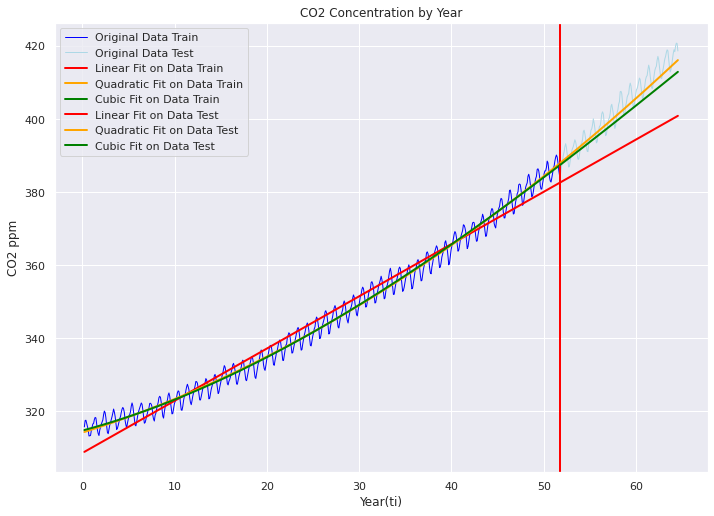

In [54]:
# Comparing Linear, Quadratic and Cubic Model Fit

plt.plot(x_train[:,0],y_train[:,0], linewidth = 1, color = 'blue', label ="Original Data Train")
plt.plot(x_test[:,0],y_test[:,0], linewidth = 1, color = 'lightblue', label ="Original Data Test")

plt.plot(x_train[:,0], y_pred_train, linewidth = 2, color = 'red', label ="Linear Fit on Data Train")
plt.plot(x_train[:,0], y_pred_train_pol2, linewidth = 2, color = 'orange', label ="Quadratic Fit on Data Train")
plt.plot(x_train[:,0], y_pred_train_pol3, linewidth = 2, color = 'green', label ="Cubic Fit on Data Train")

plt.axvline(x=x_test[0,:], ymin=0, ymax=9, linewidth = 2, color = 'red')

plt.plot(x_test[:,0], y_pred_test, linewidth = 2, color = 'red', label ="Linear Fit on Data Test")
plt.plot(x_test[:,0], y_pred_test_pol2, linewidth = 2, color = 'orange', label ="Quadratic Fit on Data Test")
plt.plot(x_test[:,0], y_pred_test_pol3, linewidth = 2, color = 'green', label ="Cubic Fit on Data Test")

plt.legend()
plt.xlabel('Year(ti)')
plt.ylabel('CO2 ppm')
plt.title('CO2 Concentration by Year')
plt.show()

## Seasonal Pattern:

For model seasonal pattern, we can use the residuals of quadratic model because this model has a good RSME besides the other models. With this residual, we need to find the pattern which can be modeled as the m



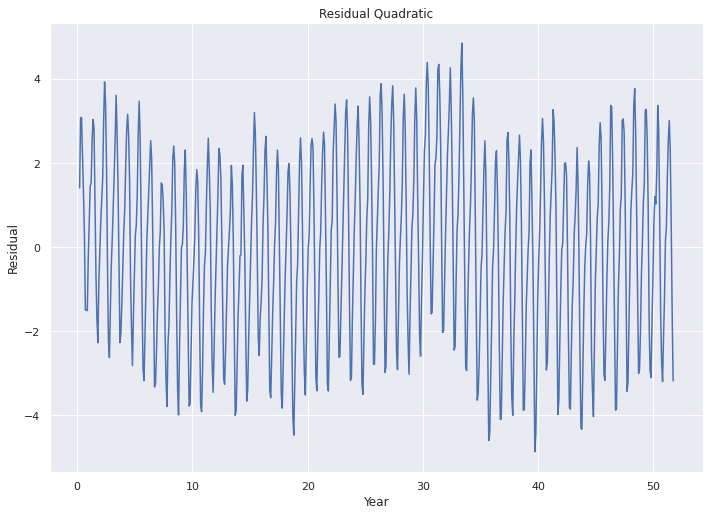

In [55]:
# Residual for Quadradic model
plt.plot(x_train[:,0], y_train - y_pred_train_pol2, color ='b')
plt.xlabel('Year')
plt.ylabel('Residual')
plt.title('Residual Quadratic')
plt.show()
plt.show()

In [41]:
# Periodic Signal on Train Data

df_co2_train["R_quadratic"] = y_train[:,0] - y_pred_train_pol2[:,0]
df_co2_train.head(10)

/home/jhon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,year,month,co2,time,R_quadratic
2,1958,3,315.71,0.208333,1.410216
3,1958,4,317.45,0.291667,3.083125
4,1958,5,317.51,0.375000,3.075866
6,1958,7,315.87,0.541667,1.300843
7,1958,8,314.93,0.625000,0.293080
8,1958,9,313.21,0.708333,-1.494852
10,1958,11,313.33,0.875000,-1.511220
11,1958,12,314.67,0.958333,-0.239656
12,1959,1,315.58,1.041667,0.601739
13,1959,2,316.49,1.125000,1.442967


There are 2 ways for model this part:
- Use the mean of months and use it as a periodic signal
- Use AR, MA model

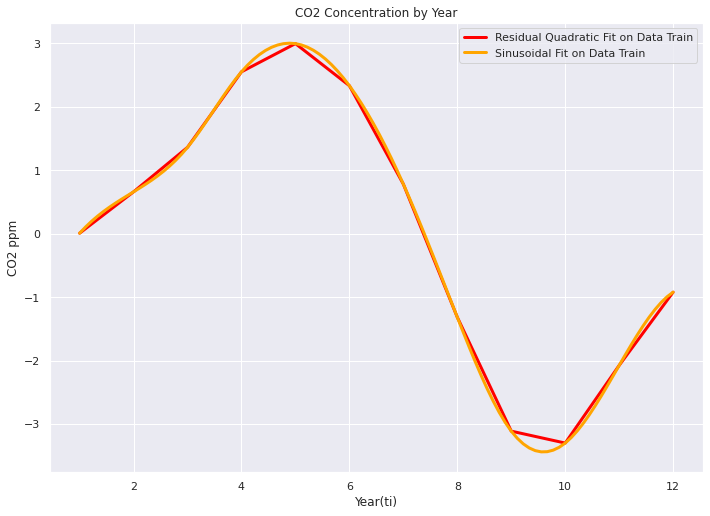

In [42]:
R_quadratic_by_month_train = df_co2_train.groupby("month").R_quadratic.mean()

Time_Signal_periodic = np.linspace(1,12,num = 100, endpoint =True)

Signal_periodic = interp1d(R_quadratic_by_month_train.index, R_quadratic_by_month_train.values, kind = 'cubic')

# Comparing Quadratic and Cubic Fit - Plotting The Keeling Curve
plt.plot(R_quadratic_by_month_train.index, R_quadratic_by_month_train.values, linewidth = 3, color = 'red', label ="Residual Quadratic Fit on Data Train")
plt.plot(Time_Signal_periodic, Signal_periodic(Time_Signal_periodic), linewidth = 3, color = 'orange', label ="Sinusoidal Fit on Data Train")
plt.legend()
plt.xlabel('Year(ti)')
plt.ylabel('CO2 ppm')
plt.title('CO2 Concentration by Year')
plt.savefig('images/scatter.png')
plt.show()

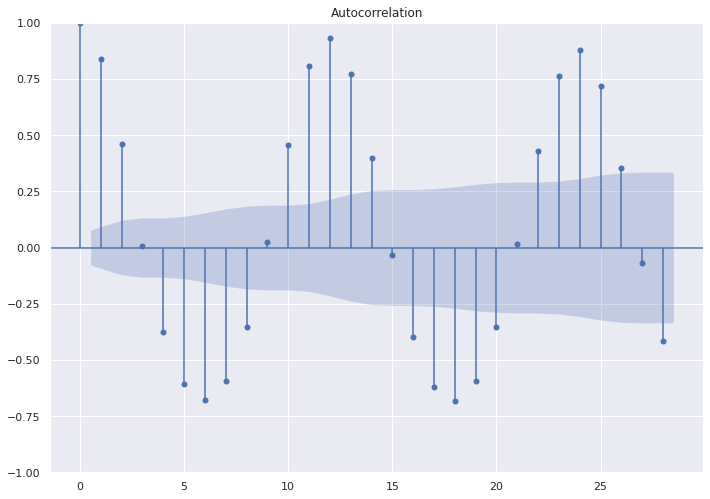

/home/jhon/anaconda3/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


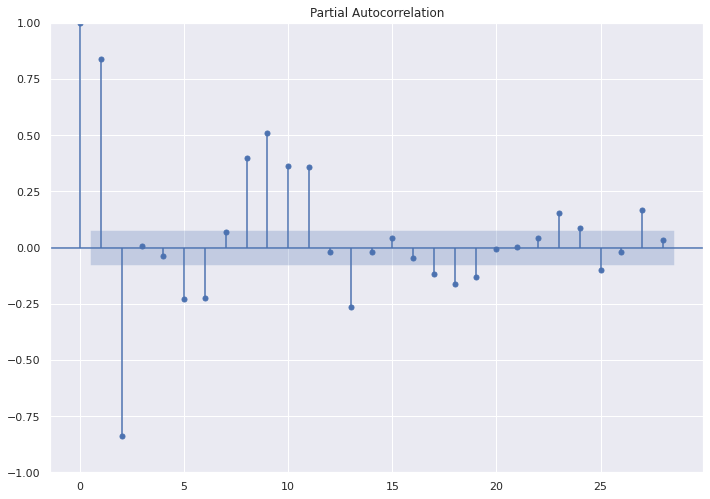

In [56]:
plot_acf(df_co2_train["R_quadratic"])
plt.show()
plot_pacf(df_co2_train["R_quadratic"])
plt.show()

# Evaluation

* Simulation exercise: 
  * Get to a stationary series 
  * Include exogenous regressors
  * Evaluate model fit with AIC/BIC 
* Is there a signal of climate change?
  * Find a model fit
  * Assess significance of climate signal